In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as tfl
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import h5py

In [2]:
def identity_block(X, f, filters, training=True, initializer=keras.initializers.random_uniform):
    """
    This Function creates an identity block for Residual Network
    
    Inputs:
    
    Returns:
        X - Tensot of shape (n_H, n_W, n_C)
    """
    
    # Get number of filters in each layer
    F1, F2, F3 = filters
    
    # Save a Copy af the short cut
    X_shortCut = X
    
    # First layer
    X = tfl.Conv2D(filters=F1, kernel_size=(1,1), strides=(1,1), padding='valid', kernel_initializer=initializer(seed=0))(X)
    X = tfl.BatchNormalization(axis=3)(X, training=training)
    X = tfl.Activation('relu')(X)
    
    # Second layer
    X = tfl.Conv2D(filters=F2, kernel_size=(f,f), strides=(1,1), padding='same', kernel_initializer=initializer(seed=0))(X)
    X = tfl.BatchNormalization(axis=3)(X, training=training)
    X = tfl.Activation('relu')(X)
    
    
    # Third layer
    X = tfl.Conv2D(filters=F3, kernel_size=(1,1), strides=(1,1), padding='valid', kernel_initializer=initializer(seed=0))(X)
    X = tfl.BatchNormalization(axis=3)(X, training=training)
    
    # Add the shortCut to X
    X = tfl.Add()([X, X_shortCut])
    
    # Then finally the activation of the last layer
    X = tfl.Activation('relu')(X)
    
    return X

In [3]:
def conv_block(X, f, filters, s=2, training=True, initializer=keras.initializers.random_uniform):
    # Get number of filters in each layer
    F1, F2, F3 = filters
    
    # Save a Copy af the short cut
    X_shortCut = X
    
    # First layer
    X = tfl.Conv2D(filters=F1, kernel_size=(1,1), strides=(s,s), padding='valid', kernel_initializer=initializer(seed=0))(X)
    X = tfl.BatchNormalization(axis=3)(X, training=training)
    X = tfl.Activation('relu')(X)
    
    # Second layer
    X = tfl.Conv2D(filters=F2, kernel_size=(f,f), strides=(1,1), padding='same', kernel_initializer=initializer(seed=0))(X)
    X = tfl.BatchNormalization(axis=3)(X, training=training)
    X = tfl.Activation('relu')(X)
    
    
    # Third layer
    X = tfl.Conv2D(filters=F3, kernel_size=(1,1), strides=(1,1), padding='valid', kernel_initializer=initializer(seed=0))(X)
    X = tfl.BatchNormalization(axis=3)(X, training=training)
    
    
    # Apply convLayer to the shortCut
    X_shortCut = tfl.Conv2D(filters=F3, kernel_size=(1,1), strides=(s,s), padding='valid', kernel_initializer=initializer(seed=0))(X_shortCut)
    X_shortCut = tfl.BatchNormalization(axis=3)(X_shortCut, training=training)
    
    
    # Add the shortCut to X
    X = tfl.Add()([X, X_shortCut])
    
    
    # Then finally the activation of the last layer
    X = tfl.Activation('relu')(X)
    
    return X

In [4]:
def ResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    This function creates Residual Network
    
    Inputs:
    
    Returns:
    
    """
    
    # Input layer
    X_input = tfl.Input(input_shape)
    
    # Padding layer
    X = tfl.ZeroPadding2D((3,3))(X_input)
    
    # Stage 1
    X = tfl.Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = keras.initializers.glorot_uniform(seed=0))(X)
    X = tfl.BatchNormalization(axis = 3)(X)
    X = tfl.Activation('relu')(X)
    X = tfl.MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = conv_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])
    
    # Stage 3 
    X = conv_block(X, f=3, filters=[128,128,512], s=2)
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    
    # Stage 4
    X = conv_block(X, f=3, filters=[256,256,1024], s=2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])


    ## Stage 5
    X = conv_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])
    
    # AVG pool layer
    X = tfl.AveragePooling2D((2,2))(X)
    
    # Last layer
    X = tfl.Flatten()(X)
    X = tfl.Dense(classes, activation='softmax', kernel_initializer = keras.initializers.glorot_uniform(seed=0))(X)
    
    model = keras.Model(inputs = X_input, outputs = X)
    
    return model

In [5]:
data_ref = h5py.File('datasets/train_signs.h5')

/home/abdalla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """Entry point for launching an IPython kernel.


In [6]:
data_ref.keys()

<KeysViewHDF5 ['list_classes', 'train_set_x', 'train_set_y']>

In [7]:
X_train = data_ref['train_set_x'][:]
y_train = data_ref['train_set_y'][:]

data_ref2 = h5py.File('datasets/test_signs.h5')

X_test = data_ref2['test_set_x'][:]
y_test = data_ref2['test_set_y'][:]

/home/abdalla/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  after removing the cwd from sys.path.


In [8]:
X_train = X_train / 255.
X_test = X_test / 255.

In [9]:
X_train.shape, X_test.shape

((1080, 64, 64, 3), (120, 64, 64, 3))

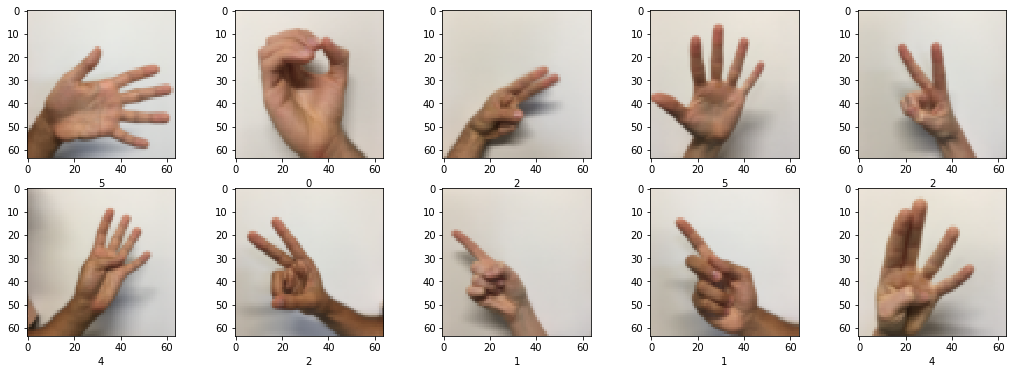

In [10]:
plt.figure(figsize=(18,6))

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(X_train[i])
    plt.xlabel(y_train[i])

In [11]:
model = ResNet50(input_shape = (64, 64, 3), classes = 6)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 64)   256         conv2d[0][0]                     
______________________________________________________________________________________________

In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
y_train = np.eye(6)[y_train.reshape(-1)]
y_test = np.eye(6)[y_test.reshape(-1)]

In [15]:
X_train.shape, y_train.shape

((1080, 64, 64, 3), (1080, 6))

In [121]:
model.fit(X_train, y_train, epochs = 10, batch_size = 32)

Epoch 1/10
34/34 [==============================] - 50s 1s/step - loss: 3.1891 - accuracy: 0.3080
Epoch 2/10
34/34 [==============================] - 46s 1s/step - loss: 0.8148 - accuracy: 0.7200
Epoch 3/10
34/34 [==============================] - 46s 1s/step - loss: 0.6781 - accuracy: 0.7507
Epoch 4/10
34/34 [==============================] - 46s 1s/step - loss: 0.5548 - accuracy: 0.7747
Epoch 5/10
34/34 [==============================] - 46s 1s/step - loss: 0.4840 - accuracy: 0.8391
Epoch 6/10
34/34 [==============================] - 46s 1s/step - loss: 1.6408 - accuracy: 0.6465
Epoch 7/10
34/34 [==============================] - 46s 1s/step - loss: 1.1619 - accuracy: 0.5964
Epoch 8/10
34/34 [==============================] - 47s 1s/step - loss: 0.9247 - accuracy: 0.7016
Epoch 9/10
34/34 [==============================] - 49s 1s/step - loss: 0.4496 - accuracy: 0.8425
Epoch 10/10
34/34 [==============================] - 47s 1s/step - loss: 0.2816 - accuracy: 0.8946


In [146]:
model.evaluate(X_test, y_test)

4/4 [==============================] - 2s 160ms/step - loss: 0.6900 - accuracy: 0.8083


[0.6899997591972351, 0.8083333373069763]

In [134]:
y_test.shape

(120, 6)

In [135]:
X_test.shape

(1080, 64, 64, 3)